## Trabalho prático #3 - Exploração e Mapeamento

#### Integrantes: 
- Filipe Rodrigues Batista de Oliveira
- Lucas Avelar

In [60]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.draw import line

def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

    # check the if both data were obtained correctly
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None

In [61]:
def Rz(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [62]:
def mostrar_mapa(mapa):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    plt.imshow(mapa, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
    # ax.imshow(linha, cmap='Reds', extent=(0, cols, rows, 0), alpha=.5)

    ax.set_xticks(np.arange(0, cols, cell_size))
    ax.set_yticks(np.arange(0, rows, cell_size))

    # ax.plot([x, xo], [y, yo], 'r-', linewidth=3)
    plt.colorbar()

In [63]:
def linha_bresenham2(inicio, fim):
    
    # Posição do robô no grid
    xi, yi = np.floor((1/cell_size) * inicio).astype(int)
    xi, yi = int(xi), int(yi)
    
    #Posição do obstáculo no grid
    xoi, yoi = np.floor((1/cell_size) * fim).astype(int)
    
    diff_x, diff_y = fim[0] - inicio[0], fim[1] - inicio[1]
    step_x, step_y = np.sign(diff_x), np.sign(diff_y)
                                         
    xOffset = 0
    if fim[0] > inicio[0]:
        xOffset = np.ceil(inicio[0]) - inicio[0]
    else:
        xOffset = inicio[0] - np.floor(inicio[0])
    
    yOffset = 0
    if fim[1] > inicio[1]:
        yOffset = np.ceil(inicio[1]) - inicio[1]
    else:
        yOffset = inicio[1] - np.floor(inicio[1])
    
    angle = np.arctan2(-diff_y, diff_x)
    tMaxX = xOffset / np.cos(angle)
    tMaxY = yOffset / np.sin(angle)
    tDeltaX = cell_size / np.cos(angle)
    tDeltaY = cell_size / np.sin(angle)
    manhattanDistance = np.abs(np.floor(fim[0]) - np.floor(inicio[0])) + np.abs(np.floor(fim[1]) - np.floor(inicio[1]))
    line_bresenham = np.zeros((rows, cols), dtype=np.uint8)
    
    i = 0
    while i <= manhattanDistance:
        line_bresenham[int(xi), int(yi)] = 1
        if np.abs(tMaxX) < np.abs(tMaxY):
            tMaxX += tDeltaX
            xi += step_x
        else:
            tMaxY += tDeltaY
            yi += step_y
        i += 1
        
    return line_bresenham

In [64]:
def inverse_sensor_model(celulas_observadas):
    ALCANCE_SENSOR, PRECISAO_SENSOR = 4, 0.5
    
    prob_leituras = []
    for celula in celulas_observadas:
        if ALCANCE_SENSOR - PRECISAO_SENSOR < np.all(celula) < ALCANCE_SENSOR + PRECISAO_SENSOR:
            s_occ = 1
        else:
            s_occ = 0

        if 0 < np.all(celula) < ALCANCE_SENSOR - PRECISAO_SENSOR:
            s_livre = 1
        else:
            s_livre = 0

        prob_leitura_celula = (1 + s_occ - s_livre) / 2
        prob_leituras.append(prob_leitura_celula)
    
    return prob_leituras

In [65]:
def occupancy_grid(caminho_percorrido, celulas_observadas):
    global m
    
    # Marca como ocupado a ultima posição que o robô estava.
    m[caminho_percorrido[-1]] = 1
    
    # Atualiza as celulas no alcance do sensor.
    m[celulas_observadas == 1] += inverse_sensor_model(celulas_observadas) - m

Program started
Connected to remote API server
Program ended


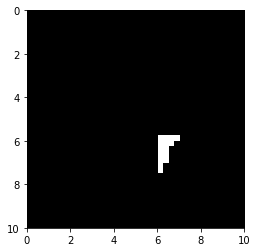

In [78]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # ATENÇÃO: Só funciona pros mapas disponibilizados.
#     map_size = np.array([20, 20])
#     cell_size = 1/4 
#     rows, cols = (map_size/cell_size).astype(int)

    map_size = np.array([10, 10])
    cell_size = 1/4 
    rows, cols = (map_size/cell_size).astype(int)
    
    
    robotname = 'kobuki'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait) 
        
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)    
    
    # Handles para os sonares
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_range_data, sim.simx_opmode_streaming + 10)
       
    # Específico do robô   
    L = 0.230
    r = 0.035
    
    v = 0
    w = np.deg2rad(0)   
    
    caminho_robo = []
    
    # Mapa inicial.
    m = np.ones((rows, cols)) / 2
    
    t = 0
    TEMPO_SIMULACAO = 5
    # Lembrar de habilitar o 'Real-time mode'
    startTime=time.time()
    lastTime = startTime
    while t < TEMPO_SIMULACAO:
        
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, orientacao = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        
        raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        pos.append(1)
        pos = np.array(pos)
        
        DIRECOES = {"frente": int(len(laser_data)/2), 
                    "direita": int(len(laser_data)*1/4),
                    "esquerda": int(len(laser_data)*3/4)}
        
        # Lógica para o robô desviar dos obstáculos.
        if laser_data[DIRECOES["frente"], 1] > 2:
            v = .3
            w = 0
        elif laser_data[DIRECOES["direita"], 1] > 2:
            v = 0
            w = np.deg2rad(-60)
        elif laser_data[DIRECOES["esquerda"], 1] > 2:
            v = 0
            w = np.deg2rad(60)
            
        #Modelo Cinemático
        wl = v/r - (w*L)/(2*r)
        wr = v/r + (w*L)/(2*r)

        # Enviando velocidades
        #sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_oneshot_wait)
        #sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_oneshot_wait)
        
        # Posição dos 'obstáculos' (posições onde o sensor leu) em relação ao referencial do robô.
        pos_obstaculos = []
        max_sensor_range=4
        
        for i in range(len(laser_data)):
            ang, dist = laser_data[i]
            
            if (max_sensor_range - dist) > 0.1:
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                
                p = np.array([x, y, 0, 1])
                pos_obstaculos.append(p)
        
        # Gera a matriz de transformação homogênea para converter da posição de um 'obstaculo' no referêncial do robô, para o referêncial global.
        T = np.row_stack((Rz(orientacao[0]), np.zeros((1,3))))
        T = np.column_stack((T, pos))
        
        # Descobre a posição do 'obstáculo' em relação ao referêncial global.
        pos_obstaculos_W = []
        for pos_obstaculo in pos_obstaculos:
            pos_obstaculos_W.append(T @ pos_obstaculo)
            
#         # Desenha as linhas de todas as direções.
#         for d in range(len(DIRECOES)):
            
#             # Caminho percorrido pelo robô no grid
#             caminho_robo.append(np.floor((1/cell_size) * pos[:2]).astype(int))
            
#             # Células que os sensores leram.
#             celulas_alcance_sensor = linha_bresenham2(pos[:2], pos_obstaculos_W[d][:2]) 
#             occupancy_grid(caminho_robo, celulas_alcance_sensor)

        caminho_robo.append(np.floor((1/cell_size) * pos[:2]).astype(int))
    
        m = np.ones((rows, cols)) + .1
        
        for obstaculo in pos_obstaculos_W:
            celulas_alcance_sensor = linha_bresenham2(pos[:2], obstaculo[:2])
            for i in range (40):#(80):
                for j in range (40):#(80):
                    if celulas_alcance_sensor[i][j] > 0:
                        m[j][i] = 0
            #occupancy_grid(caminho_robo, celulas_alcance_sensor)
            
        plt.imshow(m, cmap='Greys', origin='upper', extent=(0, 10, 10, 0))
        
        now = time.time()
        dt = now - lastTime
        t = t + dt        
        lastTime = now
       
    sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')